COVID Excess Savings by Holder

Census CEX annual data for 2019: https://www.bls.gov/cex/2019/combined/quintile.pdf

OI data: https://github.com/OpportunityInsights/EconomicTracker/tree/main/data


Version updated: 5:51pm March 5, 2021

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Copy over some values from CEX 2019 table
d = {'income': {}, 'exp': {}, 'n': {}, 
     'size': {}, 'earners': {}, 'kids':{}}

d['income']['q1'] = 12236
d['income']['q2'] = 32945
d['income']['q3'] = 53123
d['income']['q4'] = 83864
d['income']['q5'] = 174777

d['exp']['q1'] = 28672
d['exp']['q2'] = 40472
d['exp']['q3'] = 53045
d['exp']['q4'] = 71173
d['exp']['q5'] = 121571

d['n']['q1'] = 26367
d['n']['q2'] = 26387
d['n']['q3'] = 26578
d['n']['q4'] = 26375
d['n']['q5'] = 26536

d['size']['q1'] = 1.6
d['size']['q2'] = 2.2
d['size']['q3'] = 2.5
d['size']['q4'] = 2.8
d['size']['q5'] = 3.2

d['earners']['q1'] = 0.4
d['earners']['q2'] = 0.9
d['earners']['q3'] = 1.3
d['earners']['q4'] = 1.8
d['earners']['q5'] = 2.1

d['kids']['q1'] = 0.3
d['kids']['q2'] = 0.5
d['kids']['q3'] = 0.6
d['kids']['q4'] = 0.7
d['kids']['q5'] = 0.8

In [18]:
quintiles = ['q1', 'q2', 'q3', 'q4', 'q5']

# Aggregate income by quintile
d['agg_inc'] = {}
for q in quintiles:
    d['agg_inc'][q] = d['income'][q] * d['n'][q]
    
# Mean savings by quintile
d['save'] = {}
for q in quintiles:
    d['save'][q] = d['income'][q] - d['exp'][q]
    
# Aggreagte expenditure by quintile
d['agg_exp'] = {}
for q in quintiles:
    d['agg_exp'][q] = d['exp'][q] * d['n'][q]
    
# Aggregate saving by quintile
d['agg_save'] = {}
for q in quintiles:
    d['agg_save'][q] = d['save'][q] * d['n'][q]

In [19]:
total_income = sum(d['agg_inc'][q] for q in quintiles)
print('Total after tax income, in USD trillion', f'{total_income / 1_000_000_000:.2f}')
total_exp = sum(d['agg_exp'][q] for q in quintiles)
print('Total spending, in USD trillion', f'{total_exp / 1_000_000_000:.2f}')
total_save = sum(d['agg_save'][q] for q in quintiles)
print('Total savings, in USD trillion', f'{total_save / 1_000_000_000:.2f}')

Total after tax income, in USD trillion 9.45
Total spending, in USD trillion 8.34
Total savings, in USD trillion 1.12


Aggregate saving actual data from FRED

In [5]:
series = 'PMSAVE'
url = f'http://research.stlouisfed.org/fred2/series/{series}/downloaddata/{series}.csv'
df = pd.read_csv(url, index_col='DATE', parse_dates=True)
val2019 = (df.resample('AS').mean()).loc['2019-01-01'][0]
#val2019 = df.loc['2019-12-01', 'VALUE']
print('Total savings, in USD trillion (Dec 2019)', f'{val2019 / 1000: .2f}')

Total savings, in USD trillion (Dec 2019)  1.23


Aggregate spending and income

In [6]:
series = 'PCE'
url = f'http://research.stlouisfed.org/fred2/series/{series}/downloaddata/{series}.csv'
df2 = pd.read_csv(url, index_col='DATE', parse_dates=True)
pce2019 = df2.loc['2019-12-01', 'VALUE']
print('Spending, in USD trillion (Dec 2019)', f'{pce2019 / 1000: .2f}')

Spending, in USD trillion (Dec 2019)  14.80


In [7]:
series = 'DSPI'
url = f'http://research.stlouisfed.org/fred2/series/{series}/downloaddata/{series}.csv'
df3 = pd.read_csv(url, index_col='DATE', parse_dates=True)
dspi2019 = df3.loc['2019-12-01', 'VALUE']
print('After-tax income, in USD trillion (Dec 2019)', f'{dspi2019 / 1000: .2f}')

After-tax income, in USD trillion (Dec 2019)  16.57


Excess savings

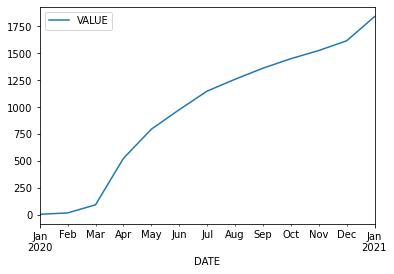

In [8]:
excess_saving = ((df.loc['2020-01-01':] - val2019) / 12).cumsum()
excess_saving.plot();

#excess_saving = ((df.loc['2020-03-01':] - 1200) / 12).cumsum()
#excess_saving.plot();

OI data

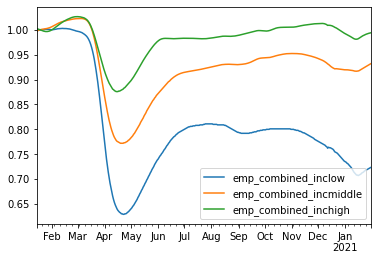

In [9]:
emp_full = pd.read_csv('Employment Combined - National - Daily.csv')
emp_full.index = pd.to_datetime(emp_full[['year', 'month', 'day']])
emp = emp_full[['emp_combined_inclow', 'emp_combined_incmiddle', 'emp_combined_inchigh']] + 1
emp.plot();

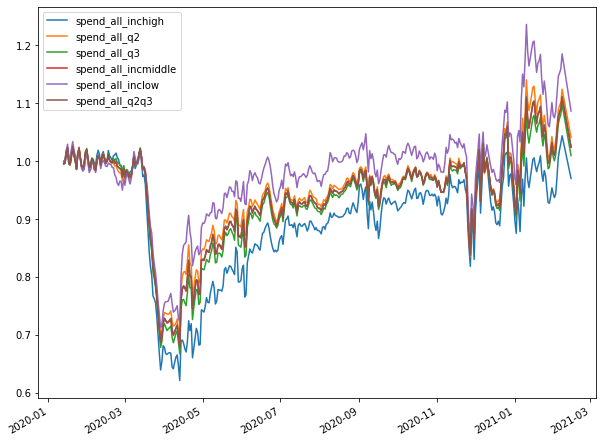

In [10]:
exp_full = pd.read_csv('Affinity - National - Daily.csv')
exp_full.index = pd.to_datetime(exp_full[['year', 'month', 'day']])
exp = exp_full.loc['2020-01-13':, ['spend_all_inchigh', 'spend_all_q2', 'spend_all_q3', 
                'spend_all_incmiddle', 'spend_all_inclow']].astype(float) + 1
exp['spend_all_q2q3'] = exp[['spend_all_q2', 'spend_all_q3']].mean(axis=1)
exp.plot(figsize=(10, 8));

In [11]:
#Convert to monthly
exp_mo = exp.resample('MS').mean()
emp_mo = emp.resample('MS').mean()

Making some assumptions.

In [12]:
# Map quintiles to employment groups
q_to_emp = {'q1': 'emp_combined_inclow',
            'q2': 'emp_combined_incmiddle',
            'q3': 'emp_combined_incmiddle',
            'q4': 'emp_combined_incmiddle',
            'q5': 'emp_combined_inchigh'}

# Map quintiles to expenditure groups
q_to_exp = {'q1': 'spend_all_inclow',
            'q2': 'spend_all_q2',
            'q3': 'spend_all_q2q3',
            'q4': 'spend_all_q3',
            'q5': 'spend_all_inchigh'}

# High income households don't get stimulus
q_to_stim = {'q1': 1, 'q2': 1, 'q3': 0.8, 'q4': 0.5, 'q5': 0}


# Amount of stimulus by month:
stim_month = {'March': 300, 'April': 1000, 'May': 200, 'June': 0,
              'July': 0, 'August': 0, 'September': 0, 'October': 0,
              'November': 0, 'December': 0, 'January': 600}

ui_month = {'March': 600, 'April': 600, 'May': 600, 'June': 600,
            'July': 600, 'August': 200, 'September': 300, 'October': 300,
            'November': 300, 'December': 300, 'January': 300}

month_dates = {'March': '2020-03-01', 'April': '2020-04-01', 
               'May': '2020-05-01', 'June': '2020-06-01',
               'July': '2020-07-01', 'August': '2020-08-01', 
               'September': '2020-09-01', 'October': '2020-10-01',
               'November': '2020-11-01', 'December': '2020-12-01', 
               'January': '2021-01-01'}

UI_wage_replacement_rate = 0.45

max_UI_weekly = 500

# Wage growth rate
wage_growth = {'March': 1.02, 'April': 1.02, 'May': 1.03, 'June': 1.03,
            'July': 1.03, 'August': 1.04, 'September': 1.04, 'October': 1.04,
            'November': 1.04, 'December': 1.05, 'January': 1.06}

2020-03-01
Est. aggregate savings, March 2.65
Actual aggregate savings, March 2.1307

Share of aggregate savings, q1 -6.4
Share of aggregate savings, q2 2.7
Share of aggregate savings, q3 10.5
Share of aggregate savings, q4 23.3
Share of aggregate savings, q5 70.0

2020-04-01
Est. aggregate savings, April 4.69
Actual aggregate savings, April 6.4136999999999995

Share of aggregate savings, q1 9.4
Share of aggregate savings, q2 12.5
Share of aggregate savings, q3 14.7
Share of aggregate savings, q4 18.3
Share of aggregate savings, q5 45.2

2020-05-01
Est. aggregate savings, May 2.74
Actual aggregate savings, May 4.4891000000000005

Share of aggregate savings, q1 -2.5
Share of aggregate savings, q2 2.5
Share of aggregate savings, q3 8.4
Share of aggregate savings, q4 18.4
Share of aggregate savings, q5 73.2

2020-06-01
Est. aggregate savings, June 2.21
Actual aggregate savings, June 3.4097

Share of aggregate savings, q1 -11.6
Share of aggregate savings, q2 -3.7
Share of aggregate savings

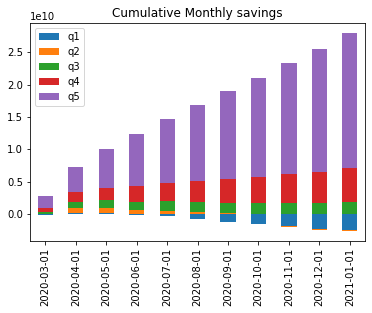

In [13]:
res = {}
final = pd.DataFrame()
final_excess = pd.DataFrame()
for month, date in month_dates.items():
    stim = stim_month[month] * 12
    ui_bump = ui_month[month]
    
    res[date] = {'ui': {}, 'stim': {}, 'inc': {}, 'exp': {}, 
                 'save': {}, 'agg_save': {}}

    for q in quintiles:
        ui_q = ((d['income']['q1'] * UI_wage_replacement_rate) / 52)
        if ui_q > max_UI_weekly:
            ui_q = max_UI_weekly
        res[date]['ui'][q] = (1 - emp_mo.loc[date, q_to_emp[q]]) * (ui_bump + ui_q) * 52
        res[date]['stim'][q] = ((stim * q_to_stim[q]) * d['size']['q1'])
        res[date]['inc'][q] = (((d['income'][q] * wage_growth[month]) * emp_mo.loc[date, q_to_emp[q]]) 
                               + res[date]['ui'][q] + res[date]['stim'][q])
        res[date]['exp'][q] = d['exp'][q] * exp_mo.loc[date, q_to_exp[q]]
        res[date]['save'][q] = res[date]['inc'][q] - res[date]['exp'][q]
        res[date]['agg_save'][q] = res[date]['save'][q] * d['n'][q]
        
    agg_save = sum(res[date]['agg_save'][q] for q in quintiles)    
    print(date)
    print(f'Est. aggregate savings, {month}', f'{agg_save / 1_000_000_000:.2f}')
    print(f'Actual aggregate savings, {month}', df.loc[date, 'VALUE'] / 1000)

    print('')
    prev_date=pd.to_datetime(date).replace(pd.to_datetime(date).year-1)
    excess_savings_date=(((df.loc[date, 'VALUE']- df.loc[prev_date, 'VALUE'])/ 1000))/12
    for q in quintiles:
        share_agg_save = (res[date]['agg_save'][q] / agg_save) * 100
        print(f'Share of aggregate savings, {q}', f'{share_agg_save:.1f}')
        final.loc[date, q] = res[date]['agg_save'][q]
        final_excess.loc[date, q] = (share_agg_save/100)*excess_savings_date
    print('')
final.cumsum().plot(kind='bar', stacked=True, title='Cumulative Monthly savings');    

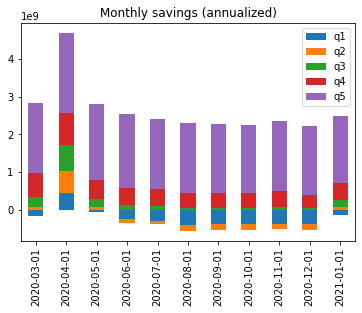

In [14]:
final.plot(kind='bar', stacked=True, title='Monthly savings (annualized)');  

Some Issues:

1) Not in the right units. Should be share of cumulative (excess?) savings

2) Lots of assumptions

3) Values are too low when compared to PMSAVE

4) 40-60th percentile group is not showing same result as Oxford Econ chart

5) Actual final result should utilize (PMSAVE - 1200) (I think)

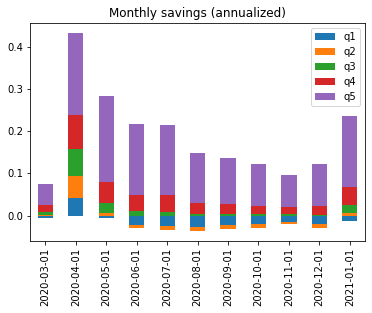

In [15]:
final_excess.plot(kind='bar', stacked=True, title='Monthly savings (annualized)');  